# LGIEKF Attitude Filter (Lie Group Invariant EKF)

This filter uses a geometrically accurate measurement correction, that is appropriate for measurements on a manifold. In this case, we measure the attitude of the vehicle relative to the magnetic field and also we measure the direction of the gravity. When the acceleration is near g, it can be assumed that the vehicle is on the ground or in a stable hover and, the direction of gravity can be use to correct the attitude.

Although the measurements are actually vectors, they are transformed into elements of SO3. One represenation of SO3 is a direction cosine matrix. From the Lie Group Extended Kalman Filter, we use a slightly modified correction term so that it is right invariant:

$$\hat{X}_{k|k} = \hat{X}_{k|k-1}\exp_{G} \left(
    K \log_{G'}\left(
        h(\hat{X}_{k|k-1}) T_y(y_k)^{-1}
    \right)
\right) $$

Here $T_y$ represents the mapping of the true measurement to the manifold. Although a bijection does not exist between SO3 and the vector measurements, a map can be constructed that is closest to the original state, so that the measurements only modifies the states that it is observing. For instance, if $y$ is measuring the magnetic heading, we wish to only induce a rotation about the down direction in the navigation frame, so we choose $T_y$ so that $\eta = h(\hat{X}_{k|k-1}) T_y(y_k)^{-1} = R_3(\xi_3)$, where $R_3$ represents a rotation around the world 3 axis.

$$ H = \frac{\partial}{\partial \boldsymbol{\xi}} \log_{G'}^{\vee} \left(
        h(\hat{X}_{k|k-1}) T_y(y_k)^{-1}
    \right)
$$

### TODO

* Streamline filtering equations
* Generate C code.

In [1]:
import sys
sys.path.insert(0, '..')

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.integrate
from IPython.display import Image
from tqdm import tqdm  # for progress bar, can install via pip
from casadi.tools.graph import graph
import casadi as ca

# this library
from pyecca.so3.mrp import Mrp
from pyecca.so3.quat import Quat

def draw_graph(x):
    g = graph.dotgraph(x)
    #g.set('dpi', 300)
    png = g.create('dot', 'png')
    return Image(png)

## Filter Derivation

In [2]:
a = Mrp(ca.SX.sym('a', 3, 1))
xh = Mrp(ca.SX.sym('xh', 3, 1))
x = Mrp(ca.SX.sym('x', 3, 1))
eta_L = (x.inv()*xh)
eta_L = ca.if_else(ca.norm_2(eta_L) > 1, eta_L.shadow(), eta_L)
log_eta_L = Mrp(eta_L).log()

eta_R = (xh*x.inv())
eta_R = ca.if_else(ca.norm_2(eta_R) > 1, eta_R.shadow(), eta_R)
log_eta_R = Mrp(eta_R).log()

q = Quat(ca.SX.sym('q', 4, 1))
w = ca.SX.sym('w', 3, 1)
fun = ca.Function("dyn", [a, w], [a.derivative(w).T])
f1 =  {
    'left_correct': ca.Function('f_right_correct', [x, w], [Mrp.exp(ca.mtimes(x.to_dcm(), w))*x]),
    'right_correct': ca.Function('f_left_correct', [x, w], [x*Mrp.exp(w)]),
    'log_eta_L': ca.Function('log_eta_L', [x, xh], [log_eta_L]),
    'log_eta_R': ca.Function('log_eta_R', [x, xh], [log_eta_R]),
    'mrp_shadow': ca.Function('mrp_shadow', [a], [a.shadow()]),
    'mrp_to_quat': ca.Function('mrp_to_quat', [a], [a.to_quat()]),
    'quat_to_euler': ca.Function('quat_to_euler', [q], [q.to_euler()]),
    'dynamics': lambda u: lambda t, x: fun(x, u),
    'measure_g': ca.Function('measure_g', [a], [a.to_dcm().T*ca.SX([0, 0, 1])]),
    'measure_hdg': ca.Function('measure_hdg', [a], [a.to_dcm().T*ca.SX([1, 0, 0])]),
}

Now we find the correction for a given alignment measurement. This can be used for both the magnetic and gravity alignment.

In [3]:
y = ca.SX.sym('y', 3, 1)
yh = ca.SX.sym('yh', 3, 1)
c_vect = ca.cross(y, yh)/ca.norm_2(y)/ca.norm_2(yh)
n_cvect = ca.norm_2(c_vect)
omega_c = ca.if_else(n_cvect > 0, ca.asin(n_cvect)*c_vect/n_cvect, ca.SX([0, 0, 0]))
f_correct_align = ca.Function('correct_align', [y, yh], [omega_c])
f2 =  {
    'correct_align': f_correct_align
}

### Prediction

In [4]:
n_x = 6

# jacobian of dynamics
eta_R = ca.SX.sym('eta_R', n_x, 1)
x = ca.SX.sym('x', n_x, 1)
xh = ca.SX.sym('x_h', n_x, 1)
rh = Mrp.exp(xh[0:3])
r = Mrp.exp(x[0:3])
re = Mrp.exp(eta_R[0:3])
be = eta_R[3:6]
dre = re.derivative(-ca.mtimes(re.to_dcm(), be))
f = ca.Function('f', [eta_R, xh], [ca.vertcat(dre, ca.SX.zeros(3))])
F = ca.Function('F', [eta_R, xh], [ca.jacobian(f(eta_R, xh), eta_R)])
Q = ca.SX.sym('Q', ca.Sparsity.diag(6))

# find sparsity pattern of P
P0 = ca.SX.sym('P0', ca.Sparsity.diag(6))
dP0 = ca.mtimes(F(eta_R, xh), P0) + ca.mtimes(P0, F(eta_R, xh).T) + Q
dP0 = ca.sparsify(ca.substitute(dP0, eta_R, ca.SX.zeros(6)))
PU = ca.SX.sym('P', ca.triu(dP0).sparsity())

# covariance prediction
P = ca.triu2symm(PU)
dP = ca.mtimes(F(eta_R, xh), P) + ca.mtimes(P, F(eta_R, xh).T) + Q
dP = ca.substitute(dP, eta_R, ca.SX.zeros(6))
dP = ca.sparsify(ca.triu2symm(ca.triu(dP))) # force symmetric, simplifies graph
f_dP = ca.Function('dP', [xh, PU, Q], [dP])

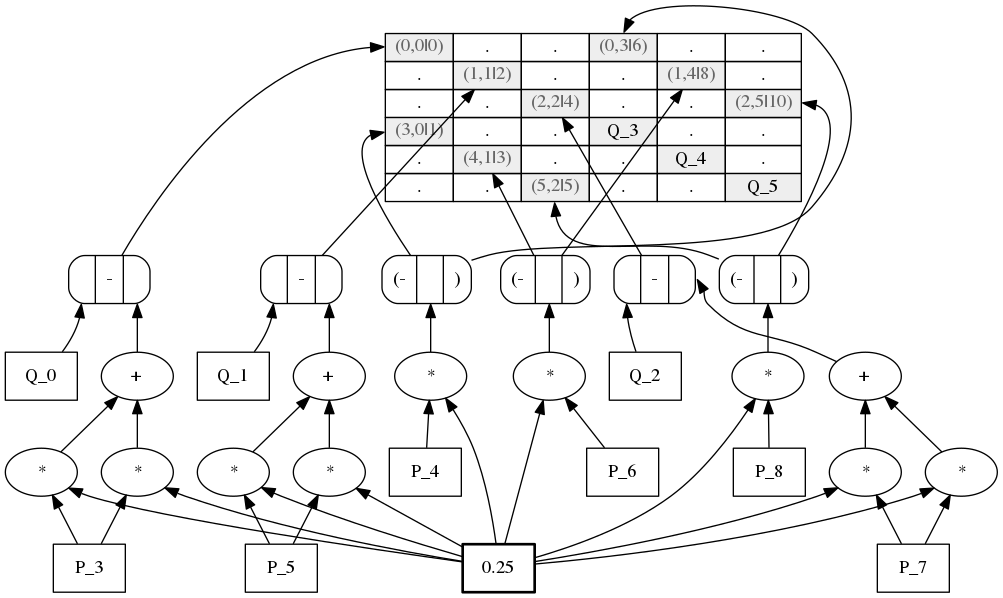

In [5]:
draw_graph(dP)

### Magnetometer Correction

For the case of the magnetic heading, we calculate:

\begin{align} H_{mag} &= \frac{\partial}{\partial \boldsymbol{\xi}} \log_{G'}^{\vee}(R_3(\xi_3)) \\
&=  \frac{\partial}{\partial \boldsymbol{\xi}} \xi_3 \\
&= \begin{pmatrix} 0 & 0 & 1\end{pmatrix}
\end{align}

In [6]:
# mag correction
H_mag = ca.SX(1, 6)
H_mag[0, 2] = 1
h_mag = ca.Function('h_mag', [x], [r.to_dcm().T * ca.SX([1, 0, 0])], ['x'], ['y_mag'])

y = ca.SX.sym('y', 3, 1)
yh = ca.SX.sym('yh', 3, 1)
c_vect = ca.cross(y, yh)/ca.norm_2(y)/ca.norm_2(yh)
n_cvect = ca.norm_2(c_vect)
omega_c = ca.if_else(n_cvect > 0, ca.asin(n_cvect)*c_vect/n_cvect, ca.SX([0, 0, 0]))
f_correct_align = ca.Function('correct_align', [y, yh], [omega_c])


yh_mag = rh.to_dcm().T * ca.SX([1, 0, 0])
f_measure_hdg = ca.Function('measure_hdg', [xh], [rh.to_dcm().T * ca.SX([1, 0, 0])])

R_mag = ca.SX.sym('R_mag', ca.Sparsity.diag(1))
S_mag = ca.mtimes([H_mag, P, H_mag.T]) + R_mag
K_mag = ca.mtimes([P, H_mag.T, ca.inv(S_mag)])
dP_mag = ca.mtimes([K_mag, H_mag, P])
dP_mag = ca.triu2symm(ca.triu(dP_mag)) # force symmetric, simplifies graph

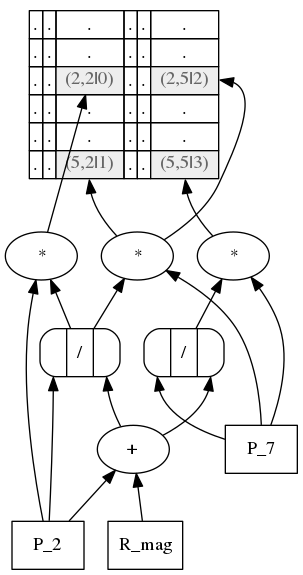

In [7]:
draw_graph(dP_mag)

In [8]:
h_mag([0, 0, 0, 0, 0, 0])

DM([1, 0, 0])

### Accelerometer Correction

For the case of the gravity alignment, we calculate:

\begin{align} H_{accel} &= \frac{\partial}{\partial \boldsymbol{\xi}} \log_{G'}^{\vee}(R_{12}(\xi_1, \xi_2)) \\
&=  \frac{\partial}{\partial \boldsymbol{\xi}} \begin{pmatrix}\xi_1 \\ \xi_2 \end{pmatrix} \\
&= \begin{pmatrix} 1 & 0 & 0 \\ 0 & 1 & 0\end{pmatrix}
\end{align}

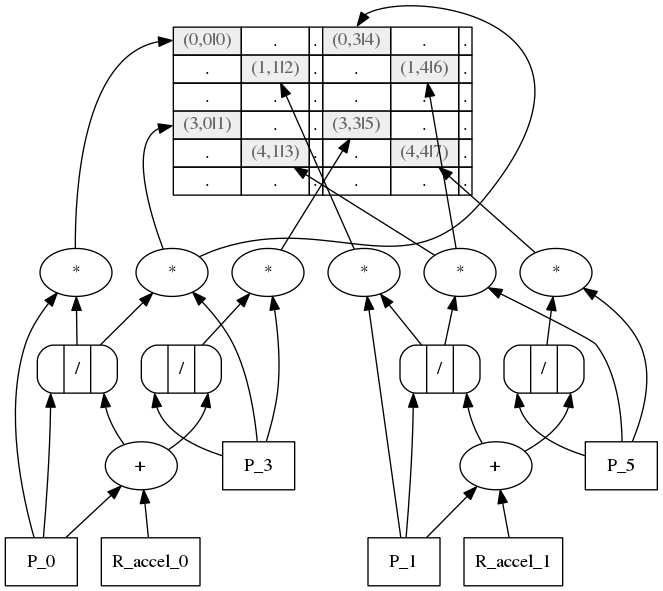

In [9]:
# accel correction
H_accel = ca.SX(2, 6)
H_accel[0, 0] = 1
H_accel[1, 1] = 1
R_accel = ca.SX.sym('R_accel', ca.Sparsity.diag(2))
S_accel = ca.mtimes([H_accel, P, H_accel.T]) + R_accel
K_accel = ca.mtimes([P, H_accel.T, ca.inv(S_accel)])
dP_accel = ca.mtimes([K_accel, H_accel, P])
dP_accel = ca.triu2symm(ca.triu(dP_accel)) # force symmetric, simplifies graph
f3 =  {
    'f': f,
    'F': F,
    'dP': f_dP,
    'dP_accel': ca.Function('dP_accel', [PU, R_accel], [dP_accel]),
    'dP_mag': ca.Function('dP_mag', [PU, R_mag], [dP_mag]),
}
draw_graph(dP_accel)

We now compile all the functions generated above and pass it to the simulation.

In [10]:
func = {}
func.update(f1)
func.update(f2)
func.update(f3)

## Simulation

In [11]:
def sim(func):
    # parameters
    t = 0
    tf = 10
    dt = 0.005 # 200 Hz

    accel_sqrt_N = 0.005  # accel sqrt of noise power
    mag_sqrt_N = 0.01  # mag sqrt of noise power
    mod_accel = 10 # 50 Hz
    mod_mag = 10 # 50 Hz
    freq = 0.1 # change rotation speed at this frequency

    # initial covariance matrix
    P = np.diag([10.0, 10.0, 10.0, 1.0, 1.0, 1.0])**2

    # process noise
    Q_sqrt_N = np.diag([0.001, 0.001, 0.001, 0.001, 0.001, 0.001])

    # initial conditions
    x = np.array([0.1, 0.2, 0.3])
    bg = 1*np.array([-0.5, 0, 0.5])

    # should delete once moved to Casadi
    H_mag = np.array([
        [0, 0, 1, 0, 0 ,0]
    ])
    H_accel = np.array([
        [1, 0, 0, 0, 0, 0],
        [0 ,1, 0, 0, 0, 0]
    ])

    # input/ disturbances
    def f_bg(t):
        """gyro bias as a function of time"""
        return 1 * np.array([-0.5, 0, 0.5]) + 0.01*np.array([1, -1, 1])* np.sin(2*np.pi*0.1*t)

    def f_omega(t):
        """angular velocity of vehicle as a function of time, in the body frame"""
        return 1*np.array([0.1, 0.2, 0.3]) + 3*np.cos(2*np.pi*freq*t)

    # all data will be stored in this dictionary, 
    hist = {}

    # noise matrices
    dt_mag = dt*mod_mag
    dt_accel = dt*mod_accel
    Q = Q_sqrt_N**2/dt
    R_accel = np.eye(2)*accel_sqrt_N**2/dt_accel
    R_mag = mag_sqrt_N**2/dt_mag

    # states
    bgh = np.zeros(3)
    q = np.reshape(func['mrp_to_quat'](x), -1)
    xh = np.array([0, 0, 0])
    qh = np.reshape(func['mrp_to_quat'](xh), -1)
    y_accel = np.reshape(func['measure_g'](x), -1)
    y_mag = np.reshape(func['measure_hdg'](x), -1)
    yh_accel = np.array([0, 0, 0])
    yh_mag = np.array([0, 0, 0])
    eta_R = np.array([0, 0, 0])
    shadow = 0 # need to track shadow state to give a consistent quaternion
    shadowh = 0 # need to track shadow state to give a consistent quaternion
    i = 0

    def handle_shadow(x, s, q):
        if np.linalg.norm(x) > 1:
            x = np.reshape(func['mrp_shadow'](x), -1)
            s = not s
        q = func['mrp_to_quat'](x)
        if s:
            q *= -1
        return x, s, q

    t_vals = np.arange(0, tf, dt)

    for t in tqdm(t_vals):
        i += 1

        bg = f_bg(t)
        omega = f_omega(t)
        
        # simulation
        res = scipy.integrate.solve_ivp(
            fun=func['dynamics'](omega), t_span=[t, t + dt],
            y0=x)
        x = np.array(res['y'][:, -1])
        x, shadow, q = handle_shadow(x, shadow, q)
        omega_meas = omega + bg

        # prediction
        resh = scipy.integrate.solve_ivp(
            fun=func['dynamics'](omega_meas - bgh), t_span=[t, t + dt],
            y0=xh)
        xh = np.array(resh['y'][:, -1])
        xh, shadowh, qh = handle_shadow(xh, shadowh, qh)

        P += np.array(func['dP'](ca.vertcat(xh, bgh), P, Q)*dt)

        # correction for accel
        if i % mod_accel == 0:
            y_accel = func['measure_g'](x)
            # the measurement here is not in the angle errors, need to account for this
            yh_accel = func['measure_g'](xh) + np.sqrt(R_accel[0, 0])*np.random.randn(3)
            S = H_accel.dot(P).dot(H_accel.T) + R_accel
            K = P.dot(H_accel.T).dot(np.linalg.inv(S))
            #print('K accel', K[0, 0], K[3, 0], K)
            # TODO, K_accel has two dimensions, same, gain though, how to handle?
            P -= np.array(func['dP_accel'](P, R_accel))
            #P -= K.dot(H_accel).dot(P)
            omega_c_accel = np.reshape(func['correct_align'](y_accel, yh_accel), -1)*K[0, 0]
            bgh = bgh + K[3, 0]*omega_c_accel
            xh = np.reshape(func['right_correct'](xh, omega_c_accel), -1)
            xh, shadowh, qh = handle_shadow(xh, shadowh, qh)


        # correction for mag
        if i % mod_mag == 0:
            y_mag = func['measure_hdg'](x) + np.sqrt(R_mag)*np.random.randn(3)
            yh_mag = func['measure_hdg'](xh)
            S = H_mag.dot(P).dot(H_mag.T) + R_mag
            K = P.dot(H_mag.T).dot(np.linalg.inv(S))
            #P -= K.dot(H_mag).dot(P)
            P -= np.array(func['dP_mag'](P, R_mag))
            #print('K mag', K[2, 0], K[5, 0])
            omega_c_mag = np.reshape(func['correct_align'](y_mag, yh_mag), -1)*K[2, 0]
            bgh = bgh + K[5, 0]*omega_c_mag
            xh = np.reshape(func['right_correct'](xh, omega_c_mag), -1)
            xh, shadowh, qh = handle_shadow(xh, shadowh, qh)

        data = ({
            't': res['t'][-1],
            'shadow': shadow,
            'shadowh': shadowh,
            'x': x,
            'y_accel': y_accel,
            'y_mag': y_mag,
            'q': q,
            'bg': bg,
            'xh': xh,
            'x': x,
            'y_accel': y_accel,
            'y_mag': y_mag,
            'q': q,
            'euler': func['quat_to_euler'](q),
            'bg': bg,
            'xh': xh,
            'yh_accel': yh_accel,
            'yh_mag': yh_mag,
            'qh': qh,
            'bgh': bgh,
            'eulerh': func['quat_to_euler'](qh),
            'log_eta_R': func['log_eta_R'](x, xh),
            'std': np.sqrt(np.reshape(np.diag(P), -1)),
        })
        for key in data.keys():
            if key not in hist.keys():
                hist[key] = []
            hist[key].append(np.reshape(data[key], -1))
        t += dt

    for k in hist.keys():
        hist[k] = np.array(hist[k])
    return hist

hist = sim(func)

100%|██████████| 2000/2000 [00:04<00:00, 461.41it/s]


## Plots

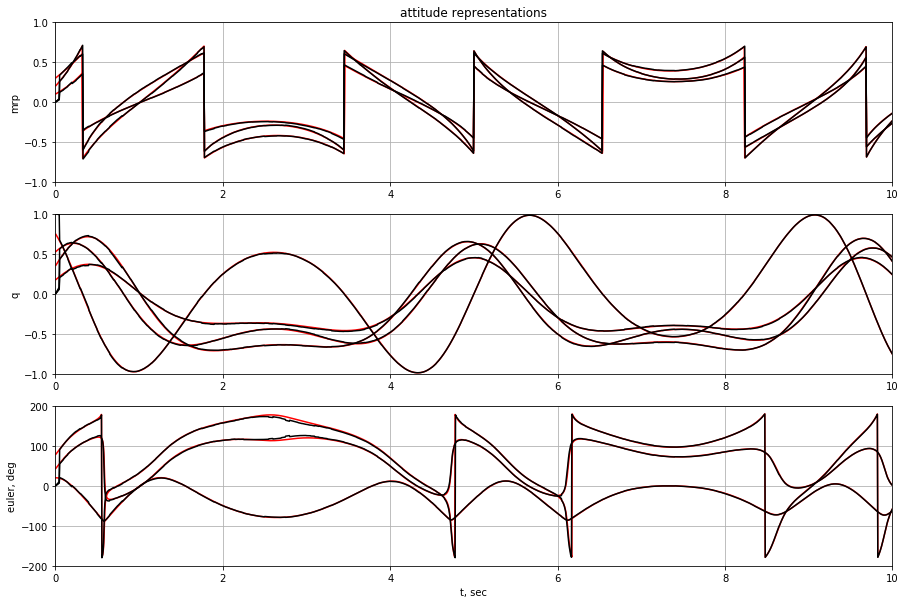

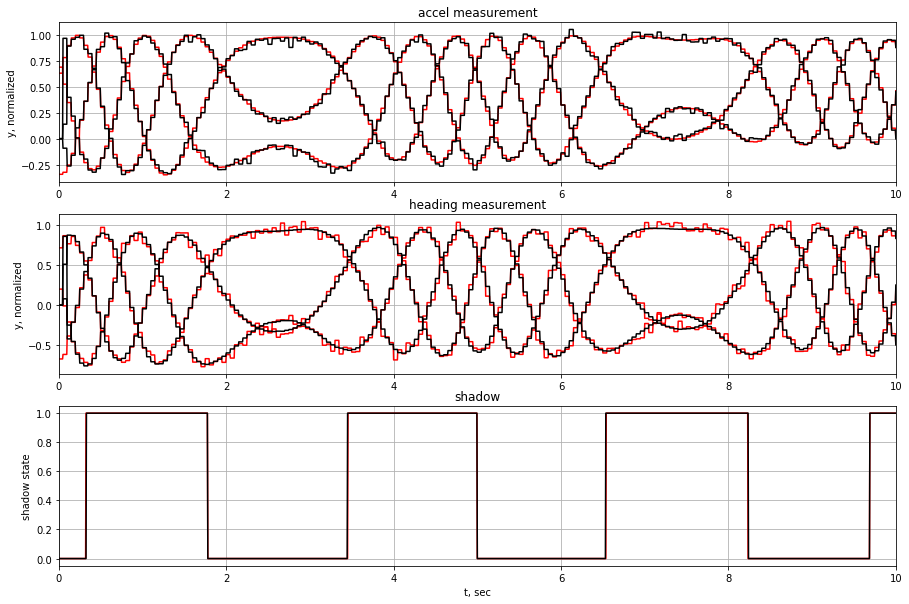

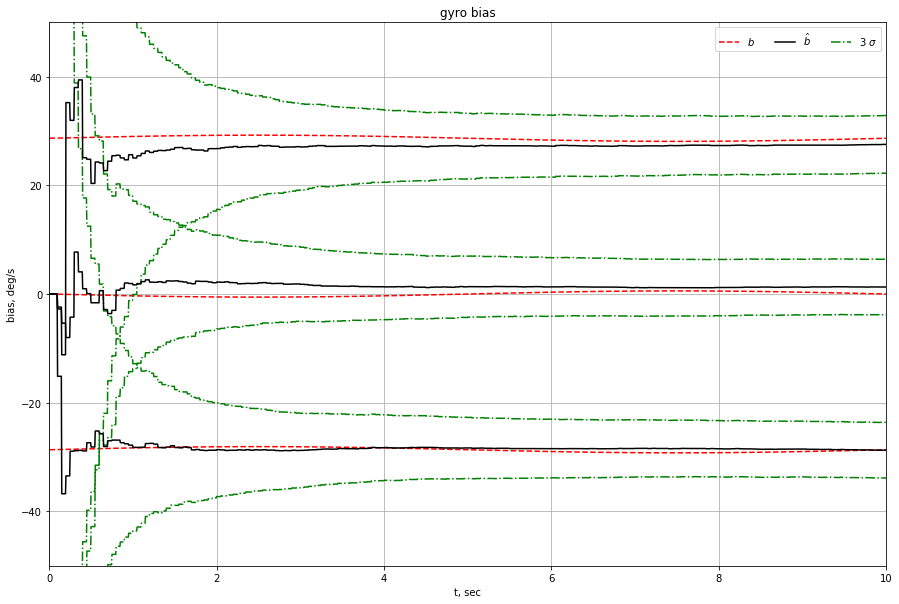

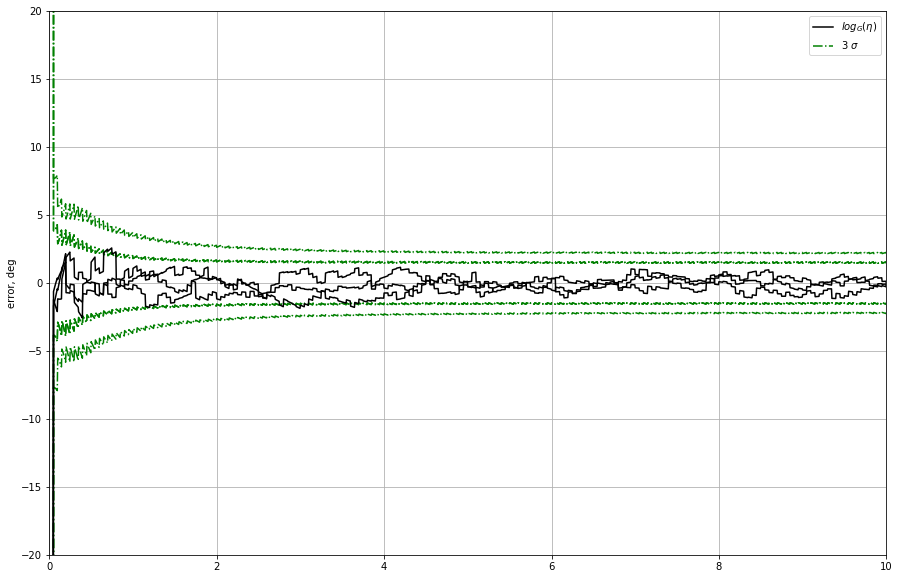

In [12]:
def plot_hist(hist, figsize = (15, 10)):
    plt.figure(figsize=figsize)
    tf = hist['t'][-1]
    
    plt.subplot(311)
    plt.plot(hist['t'], hist['x'], 'r')
    plt.plot(hist['t'], hist['xh'], 'k')
    plt.grid()
    #plt.xlabel('t, sec')
    plt.ylabel('mrp')
    plt.gca().set_ylim(-1, 1)
    plt.gca().set_xlim(0, tf)
    plt.title('attitude representations')

    plt.subplot(312)
    plt.plot(hist['t'], hist['q'], 'r')
    plt.plot(hist['t'], hist['qh'], 'k')
    #plt.xlabel('t, sec')
    plt.ylabel('q')
    plt.grid()
    plt.gca().set_ylim(-1, 1)
    plt.gca().set_xlim(0, tf)

    plt.subplot(313)
    plt.plot(hist['t'], np.rad2deg(hist['euler']), 'r')
    plt.plot(hist['t'], np.rad2deg(hist['eulerh']), 'k')
    plt.xlabel('t, sec')
    plt.ylabel('euler, deg')
    plt.grid()
    plt.gca().set_ylim(-200, 200)
    plt.gca().set_xlim(0, tf)

    plt.figure(figsize=figsize)
    plt.subplot(311)
    plt.plot(hist['t'], hist['y_accel'], 'r')
    plt.plot(hist['t'], hist['yh_accel'], 'k')
    #lt.xlabel('t, sec')
    plt.ylabel('y, normalized')
    plt.gca().set_xlim(0, tf)
    plt.grid()
    plt.title('accel measurement')

    plt.subplot(312)
    plt.plot(hist['t'], hist['y_mag'], 'r')
    plt.plot(hist['t'], hist['yh_mag'], 'k')
    #lt.xlabel('t, sec')
    plt.ylabel('y, normalized')
    plt.gca().set_xlim(0, tf)
    plt.grid()
    plt.title('heading measurement')

    plt.subplot(313)
    plt.plot(hist['t'], hist['shadow'], 'r')
    plt.plot(hist['t'], hist['shadowh'], 'k')
    plt.xlabel('t, sec')
    plt.ylabel('shadow state')
    plt.gca().set_xlim(0, tf)
    plt.grid()
    plt.title('shadow')


    plt.figure(figsize=figsize)

    #plt.subplot(311)
    h_bg = plt.plot(hist['t'], np.rad2deg(hist['bg']), 'r--')
    std_b =  hist['std'][:, 3:6]
    h_sig = plt.plot(hist['t'], np.rad2deg(hist['bgh'] + 3*std_b), 'g-.')
    plt.plot(hist['t'], np.rad2deg(hist['bgh'] -3*std_b), 'g-.')
    h_bgh = plt.plot(hist['t'], np.rad2deg(hist['bgh']), 'k')
    plt.xlabel('t, sec')
    plt.ylabel('bias, deg/s')
    plt.gca().set_xlim(0, tf)
    plt.title('gyro bias')
    plt.gca().set_ylim(-50, 50)
    plt.grid()
    plt.legend([h_bg[0], h_bgh[0], h_sig[0]],
               ['$b$', '$\hat{b}$', '3 $\sigma$'],
               loc='best', ncol=3)

    plt.figure(figsize=figsize)
    std_r =  hist['std'][:, 0:3]
    #plt.plot(hist['t'], hist['log_eta_L'], 'r', label='$log(\eta_L)$', alpha=0.3)
    h_sig = plt.plot(hist['t'], np.rad2deg(3*std_r), 'g-.')
    plt.plot(hist['t'], np.rad2deg(-3*std_r), 'g-.')
    h_eta = plt.plot(hist['t'], np.rad2deg(hist['log_eta_R']), 'k')
    plt.gca().set_ylim(-20, 20)
    plt.ylabel('error, deg')
    plt.gca().set_xlim(0, tf)
    plt.grid()
    plt.legend([h_eta[0], h_sig[0]], ['$log_G(\eta)$', '3 $\sigma$'], loc='best')

    plt.show()

plot_hist(hist)